In [37]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import skfda
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import scipy.linalg
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import  StratifiedKFold
from sklearn.model_selection import KFold
#import os
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import backend as K



import  numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle


from sklearn import preprocessing

import pandas as pd
import numpy as np
import matplotlib

matplotlib.use('AGG')  # 或者PDF, SVG或PS

import matplotlib.pyplot as plt

import tensorflow
import time

 F:\Anaconda\lib\site-packages\ipykernel_launcher.py:38: UserWarning:
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "F:\Anaconda\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "F:\Anaconda\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "F:\Anaconda\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "F:\Anaconda\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "F:\Anaconda\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "F:\Anaconda\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.async

# Display data

(2118,)


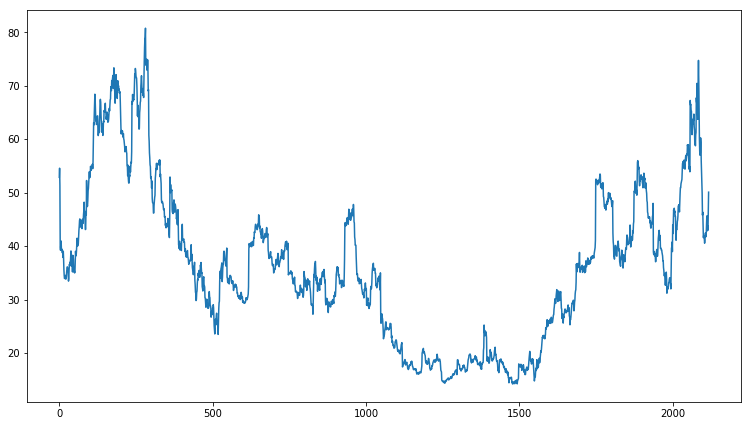

In [38]:
f=open('C:\\Users\\HP\Desktop\\plot\\twitter.csv','rb')
df=pd.read_csv(f,encoding='gb18030')    


data=np.array(df['High'])   
print(data.shape)
data=data[::-1]     

plt.figure()
plt.plot(data)
plt.show()

min_max_scaler = preprocessing.MinMaxScaler()
normalize_data = min_max_scaler.fit_transform(data.reshape(-1,1))



# Form training set

In [39]:


time_step=7      

train_x,train_y=[],[]    
for i in range(len(normalize_data)-time_step-1):
    x=normalize_data[i:i+time_step]
    y=normalize_data[i+1:i+time_step+1]
    train_x.append(x.tolist())
    train_y.append(y.tolist())

x_full_train = np.array(train_x)
y_full_train = np.array(train_y)
#y_full_train = np.squeeze(y_full_train,axis=2)
print(x_full_train.shape)
print(y_full_train.shape)

(2110, 7, 1)
(2110, 7, 1)


In [40]:

def BasisExpansion(q, t, lb=0, ub=1):
    bas = skfda.representation.basis.BSpline(n_basis=q, domain_range=(lb, ub))
    #bas = skfda.representation.basis.Fourier(n_basis=q, domain_range=(lb, ub))
    Bt = np.squeeze(bas.evaluate(t))
    return Bt





p = 5  # number of basis functions
T = 7  # number of time points
t = np.linspace(0, 1, T)   # tim grid
basis = "bspline"   # choice of first basis
#basis2 = "bspline"  # choice of second basis
h = 10    # hidden layer numbers
activation = 'tanh'  #Activation function selection
lr = 1e-3   #learning rate
epoch = 30
num_layers = 1  #the number of layers
'''
To change the number of hidden layers, change the dimension of B. 
For example, if the number of hidden layers is, 
then B= scipy.linalg.block_diag(Bt, Bt, Bt, Bt, Bt)  
'''


epoch = epoch
batch_size = 32
metric = keras.metrics.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)





# RNN

In [41]:
class MyRNNCell(keras.layers.Layer):

    def __init__(self, units,
                 activation = None,
                 kernel_initializer='orthogonal',
                 use_bias=True,
                 **kwargs):
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.state_size = units


        super(MyRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1] + self.units, self.units),
                                 initializer=self.kernel_initializer,
                                 name='W')
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer='uniform',
                                        name='bias')

        self.built = True

    def call(self, inputs, states):
        Ht = states[0]
        cat = tf.concat((Ht, inputs), -1)  # Concatenate Ht with input X
        Ht = tf.matmul(cat, self.W)
        #print(Ht.shape)
        if self.use_bias:
            Ht = Ht + self.bias
        if self.activation is not None:
            Ht = self.activation(Ht)

        return Ht, [Ht]


In [ ]:

epoch_list1=[]
loss_list1=[]
model8 = Sequential()

for i in range(num_layers-1):
    model8.add(RNN(MyRNNCell(h, activation=activation), return_sequences=True))
model8.add(RNN(SimpleRNNCell(h,activation=activation),return_sequences=True))
model8.add(tf.keras.layers.Dropout(0.2))
model8.add(tf.keras.layers.Dense(1))
'''
model8.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr,decay = 0.0),
               loss = 'mean_squared_error',metrics=['mean_squared_error'])
history8 = model8.fit(x_full_train,y_full_train,batch_size=batch_size,validation_data=(x_full_test,true_full_test),epochs=epoch,verbose=1)
'''
num_epoch = 1000 #number of training times
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4)#optimizer
epoch_list1=[]
loss_list1=[]
for e in range(num_epoch):
    # Use tf.GradientTape() to record the gradient information of the loss function
    with tf.GradientTape() as tape:
        y_pred = model8(x_full_train )  #training set prediction
        loss = tf.reduce_mean(tf.square(y_pred - y_full_train)) #training set loss   
    # TensorFlow automatically calculates the gradient of the loss function with respect to the independent variables (model parameters)
    grads = tape.gradient(loss, model8.trainable_variables) #calculate gradients
     #print('before:',grads[0].numpy(),end='\t')

    #grads=[tf.clip_by_value(g,clip_value_min=-1e3, clip_value_max=6e-6, name=None)
           #for g in grads] #gradient clipping
    #print('after:',grads[0].numpy(),end='\t')
    #print('loss:',loss)

    #TensorFlow automatically updates parameters based on gradient
    optimizer.apply_gradients(grads_and_vars=zip(grads, model8.trainable_variables))#update parameters
    
    test_pred = model8(x_full_train)#testing set prediction
    testloss = tf.reduce_mean(tf.square(test_pred - y_full_train))#testing set loss
    if e%100==0:
        epoch_list1.append(e)
        loss_list1.append(testloss.numpy())
        print('epochs : {}, train_loss : {}, test_loss : {}'.format(e,loss.numpy(),testloss.numpy()))

# ETV-RNN

In [43]:
class MinimalRNNCell(keras.layers.Layer):

    def __init__(self, units, q,
                 activation=None,
                 kernel_initializer='orthogonal',
                 use_bias=True,
                 **kwargs):
        self.units = units
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.q = q
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.state_size = units
        super(MinimalRNNCell, self).__init__(**kwargs)
        self.k =  np.linspace(0, 1, T)
        self.m = 0
        self.update = 0
        self.steps = T

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1] + self.units, self.units),
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.Q = self.add_weight(
            shape=(self.units, self.q * self.units ),  # theta-matrix to be optimized
            initializer=self.kernel_initializer,
            name='theta')
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer='uniform',
                                        name='bias')

        self.built = True

    def call(self, inputs, states):
        # K.clear_session()
        Ht = states[0]
        # h = tf.matmul(inputs, self.W)
        self.t1 = self.k[self.m]
        Bt = BasisExpansion(self.q, self.t1)
        B = Bt
        for i in range(self.units - 1):
            B = scipy.linalg.block_diag(B, Bt)



        self.update = tf.matmul(self.Q, B.T)
        self.BM = self.update          # The Change matrix
        cat = tf.concat((Ht, inputs), -1)  
        Ht = tf.matmul(cat, self.W)
        Ht = tf.matmul(Ht, self.BM)    # Update the Ht
        if self.use_bias:
            Ht = Ht + self.bias
        if self.activation is not None:
            Ht = self.activation(Ht)
            #St = self.activation(St)
        self.m += 1
        if self.m == self.steps:
            self.m = 0
            self.update = 0

        return Ht, [Ht]

In [ ]:

epoch_list3=[]
loss_list3=[]
model3 = Sequential()

for i in range(num_layers-1):
    model3.add(RNN(MinimalRNNCell(h,q=p, activation=activation), return_sequences=True))
model3.add(RNN(MinimalRNNCell(h,q=p,activation=activation),return_sequences=True))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(1))
'''
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr,decay = 0.0),
               loss = 'mean_squared_error',metrics=['mean_squared_error'])
history3 = model3.fit(x_full_train,y_full_train,batch_size=batch_size,validation_data=(x_full_test,true_full_test),epochs=epoch,verbose=1)
'''
num_epoch = 1000 #number of training times
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4)#optimizer
for e in range(num_epoch):
    # Use tf.GradientTape() to record the gradient information of the loss function
    with tf.GradientTape() as tape:
        y_pred = model3(x_full_train )  #training set prediction
        loss = tf.reduce_mean(tf.square(y_pred - y_full_train)) #training set loss   
    # TensorFlow automatically calculates the gradient of the loss function with respect to the independent variables (model parameters)
    grads = tape.gradient(loss, model3.trainable_variables) #calculate gradients

    #TensorFlow automatically updates parameters based on gradient
    optimizer.apply_gradients(grads_and_vars=zip(grads, model3.trainable_variables))#update parameters
    
    test_pred = model3(x_full_train)#testing set prediction
    testloss = tf.reduce_mean(tf.square(test_pred - y_full_train))#testing set loss
    if e%100==0:
        epoch_list3.append(e)
        loss_list3.append(testloss.numpy())
        print('epochs : {}, train_loss : {}, test_loss : {}'.format(e,loss.numpy(),testloss.numpy()))
        


# Show the results

In [48]:
pred_1=model8(x_full_train)
pred_2=model3(x_full_train)
pred_3=model3(x_full_train)


a= y_full_train[0]
for i in range(300):
    #print(i)
    a = np.vstack((a,y_full_train[7*(i+1)]))
a = min_max_scaler.inverse_transform(a)
b = np.squeeze(a,axis = 1)

print(pred_1.shape)
rnn= pred_1[0]
for i in range(300):
    #print(i)
    rnn = np.vstack((rnn,pred_1[7*(i+1)]))
print(rnn.shape)
rnn = min_max_scaler.inverse_transform(rnn)
rnn = np.squeeze(rnn,axis = 1)

print(pred_2.shape)
ernn= pred_2[0]
for i in range(300):
    #print(i)
    ernn = np.vstack((ernn,pred_2[7*(i+1)]))
print(ernn.shape)
ernn = min_max_scaler.inverse_transform(ernn)
ernn = np.squeeze(ernn,axis = 1)


(2110, 7, 1)
(2107, 1)


<Figure size 921.6x518.4 with 0 Axes>

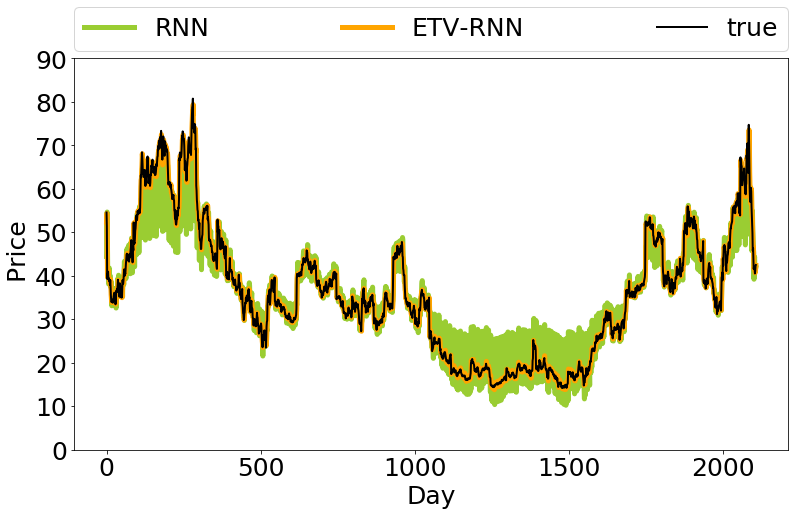

In [58]:
plt.figure()
fig,ax=plt.subplots() #canvas size
plt.rcParams['figure.figsize']=(12.8, 7.2)

#plt.plot(b,label='label',color='black')
plt.plot(rnn,label='RNN',color='yellowgreen',lw = 5)
plt.plot(ernn,label='ETV-RNN',color='orange',lw = 5)
plt.plot(b,label='true',color='black',lw = 2)
plt.legend(bbox_to_anchor=(0,1.02,1.0,0.5), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Day',fontsize=25)
plt.ylabel(' Price',fontsize=25)
plt.ylim([0, 90])
plt.savefig("C:\\Users\\HP\\Desktop\\tw-rnn.png")
plt.show()

# LSTM

In [50]:
class MYLSTM1(keras.layers.Layer):

    def __init__(self, units,
                 kernel_initializer='orthogonal',
                 **kwargs):
        super(MYLSTM1, self).__init__()
        self.units = units
        self.state_size = units
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        super(MYLSTM1, self).build(input_shape)
        self.Wf = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wf',
                                  trainable=True)

        self.Wi = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wi',
                                  trainable=True)

        self.Wc = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wa',
                                  trainable=True)

        self.Wo = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wo',
                                  trainable=True)

        self.built = True

    def call(self, inputs, states):
        xt = inputs
        Ht = states[0]
        Ct = states[0]
        cat = tf.concat((Ht, xt), -1)             # Concatenate Ht with input X
        Ft = tf.sigmoid(tf.matmul(cat, self.Wf))  # Forget gate
        It = tf.sigmoid(tf.matmul(cat, self.Wi))  # Input gate
        Gt = tf.sigmoid(tf.matmul(cat, self.Wc))
        Ct = It * Gt + Ft * Ct                    # Update the Ct
        Ot = tf.tanh(tf.matmul(cat, self.Wo))     # Output gate
        Ht = Ot * tf.tanh(Ct)                     # Update the Ht
        Ct = tf.tanh(Ct)
        return Ht, [Ct]

In [ ]:

epoch_list4=[]
loss_list4=[]
model5 = Sequential()

for i in range(num_layers-1):
    model5.add(RNN(MYLSTM1(h, activation=activation), return_sequences=True))
model5.add(RNN(MYLSTM1(h,activation=activation),return_sequences=True))
model5.add(tf.keras.layers.Dropout(0.2))
model5.add(tf.keras.layers.Dense(1))
'''
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr,decay = 0.0),
               loss = 'mean_squared_error',metrics=['mean_squared_error'])
history5 = model5.fit(x_full_train,y_full_train,batch_size=batch_size,validation_data=(x_full_test,true_full_test),epochs=epoch,verbose=1)
'''
num_epoch = 1000 #number of training times
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4)#optimizer
for e in range(num_epoch):
    # Use tf.GradientTape() to record the gradient information of the loss function
    with tf.GradientTape() as tape:
        y_pred = model5(x_full_train )  #training set prediction
        loss = tf.reduce_mean(tf.square(y_pred - y_full_train)) #training set loss   
    # TensorFlow automatically calculates the gradient of the loss function with respect to the independent variables (model parameters)
    grads = tape.gradient(loss, model5.trainable_variables) #calculate gradients

    #TensorFlow automatically updates parameters based on gradient
    optimizer.apply_gradients(grads_and_vars=zip(grads, model5.trainable_variables))#update parameters
    
    test_pred = model5(x_full_train)#testing set prediction
    testloss = tf.reduce_mean(tf.square(test_pred - y_full_train))#testing set loss
    if e%100==0:
        epoch_list4.append(e)
        loss_list4.append(testloss.numpy())
        print('epochs : {}, train_loss : {}, test_loss : {}'.format(e,loss.numpy(),testloss.numpy()))
        


In [52]:
class MYLSTM_2(keras.layers.Layer):

    def __init__(self, units, q,
                 kernel_initializer='orthogonal',
                 **kwargs):
        super(MYLSTM_2, self).__init__()
        self.units = units
        self.state_size = units
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.q = q
        self.k = np.linspace(0, 1, T)
        self.m = 0
        self.t = 0
        self.update = 0
        self.steps = T

    def build(self, input_shape):
        super(MYLSTM_2, self).build(input_shape)
        self.Wf = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wf',
                                  trainable=True)

        self.Wi = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wi',
                                  trainable=True)

        self.Wc = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wc',
                                  trainable=True)

        self.Wo = self.add_weight(shape=(input_shape[-1] + self.units, self.units),

                                  initializer=self.kernel_initializer,
                                  name='Wo',
                                  trainable=True)

        # self.U = self.add_weight(
        # shape=(self.units, self.units),
        # initializer='uniform',
        # name='U')

        self.Q = self.add_weight(
            shape=(self.units, self.q * self.units),  
            initializer=self.kernel_initializer,
            name='theta')

        self.Q2 = self.add_weight(
            shape=(self.units, self.q * self.units), 
            initializer=self.kernel_initializer,
            name='theta2')

        self.built = True

    def call(self, inputs, states):
        # K.clear_session()
        xt = inputs
        Ht = states[0]
        Ct = states[0]

        self.t1 = self.k[self.m]
        Bt = BasisExpansion(self.q, self.t1)
        B = Bt
        for i in range(self.units - 1):
            B = scipy.linalg.block_diag(B, Bt)

        self.update = tf.matmul(self.Q, B.T)
        self.BM = self.update                      #Change matrix 1
        self.BM2 = tf.matmul(self.Q2, B.T)         #Change matrix 2
        cat = tf.concat((Ht, inputs), -1)         # Concatenate Ht with input X
        Ft = tf.sigmoid(tf.matmul(cat, self.Wf))  # Forget gate
        It = tf.sigmoid(tf.matmul(cat, self.Wi))  # Input gate
        Gt = tf.sigmoid(tf.matmul(cat, self.Wc))
        Ct = It * Gt + Ft * Ct  # update the Ct
        Ot = tf.tanh(tf.matmul(cat, self.Wo))     # Output  gate
        # Ht = Ot * tf.tanh(Ct)
        # Ct = tf.matmul(Ct, self.U)
        St = Ot * tf.tanh(Ct)
        Ht = tf.tanh(tf.matmul(St, self.BM))       # update the Ht
        Ct = tf.tanh(tf.matmul(Ct, self.BM2))      # update the Ct
        # Ct = tf.tanh(Ct)
        # print(Ct)
        self.m += 1
        if self.m == self.steps:
            self.m = 0
            self.update = 0

        return Ht, [Ct]

In [ ]:

epoch_list6=[]
loss_list6=[]
model7 = Sequential()

for i in range(num_layers-1):
    model7.add(RNN(MYLSTM_2(h,q=p), return_sequences=True))
model7.add(RNN(MYLSTM_2(h,q=p),return_sequences=True))
model7.add(tf.keras.layers.Dropout(0.2))
model7.add(tf.keras.layers.Dense(1))
'''
model7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr,decay = 0.0),
               loss = 'mean_squared_error',metrics=['mean_squared_error'])
history7 = model7.fit(x_full_train,y_full_train,batch_size=batch_size,validation_data=(x_full_test,true_full_test),epochs=epoch,verbose=1)
'''
num_epoch = 1000 #number of training times
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4)#optimizer
for e in range(num_epoch):
    # Use tf.GradientTape() to record the gradient information of the loss function
    with tf.GradientTape() as tape:
        y_pred = model7(x_full_train )  #training set prediction
        loss = tf.reduce_mean(tf.square(y_pred - y_full_train)) #training set loss   
    # TensorFlow automatically calculates the gradient of the loss function with respect to the independent variables (model parameters)
    grads = tape.gradient(loss, model7.trainable_variables) #calculate gradients

    #TensorFlow automatically updates parameters based on gradient
    optimizer.apply_gradients(grads_and_vars=zip(grads, model7.trainable_variables))#update parameters
    
    test_pred = model7(x_full_train)#testing set prediction
    testloss = tf.reduce_mean(tf.square(test_pred - y_full_train))#testing set loss
    if e%100==0:
        epoch_list6.append(e)
        loss_list6.append(testloss.numpy())
        print('epochs : {}, train_loss : {}, test_loss : {}'.format(e,loss.numpy(),testloss.numpy()))
        


In [ ]:
pred_4=model5(x_full_train)
pred_6=model7(x_full_train)
print(pred_4.shape)
lstm= pred_4[0]
for i in range(300):
    #print(i)
    lstm = np.vstack((lstm,pred_4[7*(i+1)]))
print(lstm.shape)
lstm = min_max_scaler.inverse_transform(lstm)
lstm = np.squeeze(lstm,axis = 1)

print(pred_6.shape)
elstm= pred_6[0]
for i in range(300):
    #print(i)
    elstm = np.vstack((elstm,pred_6[7*(i+1)]))
print(elstm.shape)
elstm = min_max_scaler.inverse_transform(elstm)
elstm = np.squeeze(elstm,axis = 1)

<Figure size 921.6x518.4 with 0 Axes>

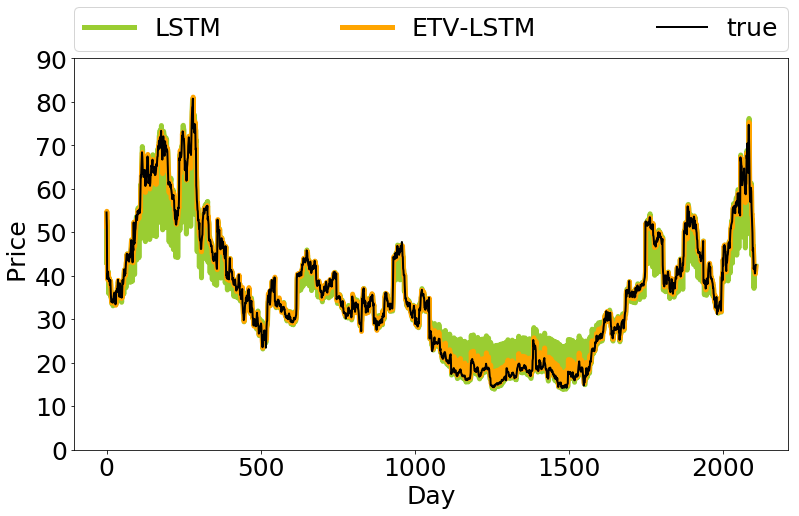

In [59]:
plt.figure()
fig,ax=plt.subplots() #canvas size
plt.rcParams['figure.figsize']=(12.8, 7.2)

#plt.plot(b,label='label',color='black')
plt.plot(lstm,label='LSTM',color='yellowgreen',lw = 5)
plt.plot(elstm,label='ETV-LSTM',color='orange',lw = 5)
plt.plot(b,label='true',color='black',lw = 2)
plt.legend(bbox_to_anchor=(0,1.02,1.0,0.5), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Day',fontsize=25)
plt.ylabel(' Price',fontsize=25)
plt.ylim([0, 90])
plt.savefig("C:\\Users\\HP\\Desktop\\tw-lstm.png")
plt.show()